## Trabajo Práctico N°1: modelo predictivo de tarifas de Uber
Integrantes: Sebastian Palacio, Juana Chies Doumecq

#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path) 

In [38]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [39]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [40]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                200000 non-null  int64              
 1   date               200000 non-null  object             
 2   fare_amount        200000 non-null  float64            
 3   pickup_datetime    200000 non-null  datetime64[ns, UTC]
 4   pickup_longitude   200000 non-null  float64            
 5   pickup_latitude    200000 non-null  float64            
 6   dropoff_longitude  199999 non-null  float64            
 7   dropoff_latitude   199999 non-null  float64            
 8   passenger_count    200000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2), object(1)
memory usage: 13.7+ MB


In [42]:
# agregar mas columnas despues
columnas_numericas = ['fare_amount', 'pickup_longitude',
                      'pickup_latitude', 'dropoff_longitude',
                      'dropoff_latitude','passenger_count']

Manejo de nulos

In [43]:
#Primero verificamos las columnas que contienen valores nulos

df.isnull().sum()

df[df.isnull().any(axis=1)] 

df.shape
df = df.dropna()
df.shape

(199999, 9)

Manejo de valores ilógicos

In [44]:
df[df['fare_amount'] < 0].count()

key                  17
date                 17
fare_amount          17
pickup_datetime      17
pickup_longitude     17
pickup_latitude      17
dropoff_longitude    17
dropoff_latitude     17
passenger_count      17
dtype: int64

In [45]:
df = df[df['fare_amount'] >= 0] 

Manejo de valores atípicos

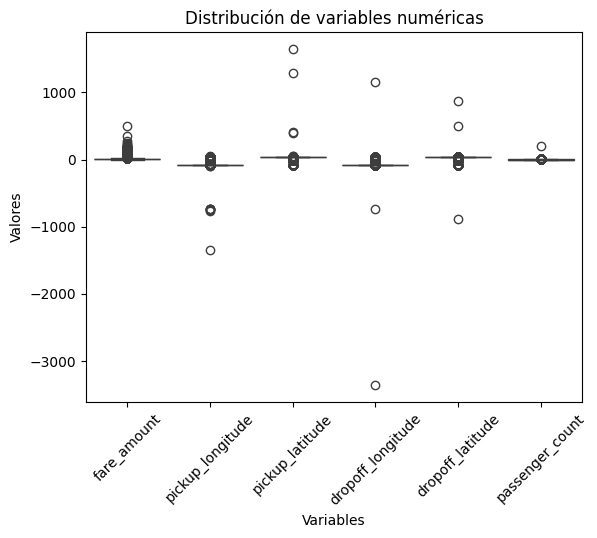

In [46]:
sns.boxplot(data=df[columnas_numericas])
plt.title('Distribución de variables numéricas')
plt.xticks(rotation=45)
plt.xlabel('Variables')
plt.ylabel('Valores')
plt.show()

In [47]:
# saco atipicos de passenger count, asumo que en los otros puede haber atipicos?
df['passenger_count'].value_counts().sort_index()

passenger_count
0         708
1      138416
2       29426
3        8878
4        4276
5       14006
6        4271
208         1
Name: count, dtype: int64

In [56]:
## TEORIA ATIPICOS no funciona, me me saca datos de 4, 5, 6 pasajeros y deja 0???
# Q1 = df['passenger_count'].quantile(0.25)
# Q3 = df['passenger_count'].quantile(0.75)
# IQR = Q3 - Q1

# lim_inf = Q1 - 1.5 * IQR
# lim_sup = Q3 + 1.5 * IQR

# df = df[(df['passenger_count'] >= lim_inf) & (df['passenger_count'] <= lim_sup)]



# asumimos que tienen que ser mas de 0 pasajeros y menos de 7 (pero menos de 0 hay como 700, ver eso)
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]
df['passenger_count'].value_counts().sort_index()

passenger_count
1    138416
2     29426
3      8878
4      4276
5     14006
6      4271
Name: count, dtype: int64

Visualizacion de datos

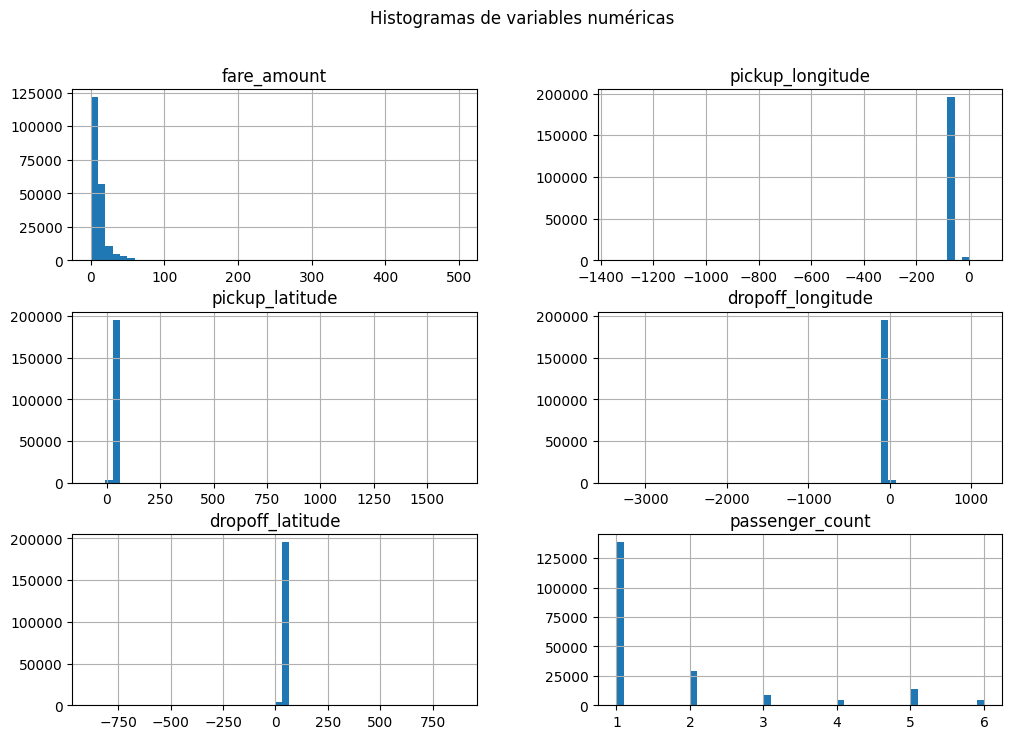

In [49]:
df[columnas_numericas].hist(figsize=(12, 8), bins=50)
plt.suptitle("Histogramas de variables numéricas")
plt.show()

In [50]:
# sns.pairplot(df[columnas_numericas]) 
# 12 minutos ejecutandose no se que paso

<Axes: >

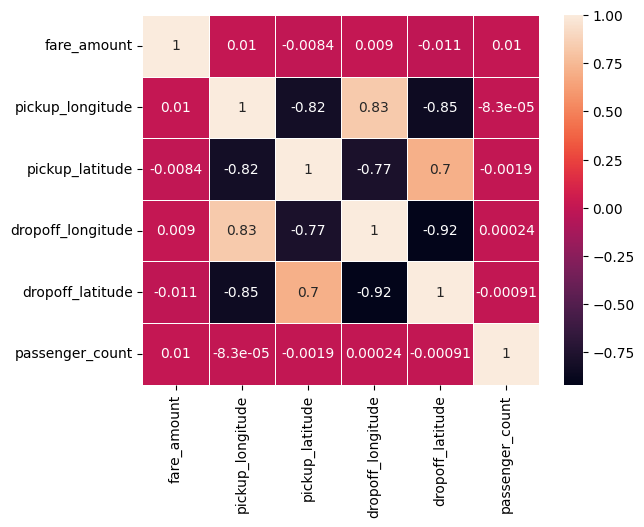

In [51]:
corrmat = df[columnas_numericas].corr()

sns.heatmap(corrmat, vmax=1, annot=True, linewidths=.5)

DIVIDO DATOS (DESPUES DE LIMPIEZA)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [53]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.594180e+05,159418.000000,159418.000000,159418.000000,159418.000000,159418.000000
mean,2.770416e+07,-72.524649,39.931906,-72.510360,39.922076,1.688918
std,1.600329e+07,10.945234,6.847963,10.968205,6.606728,1.306013
min,1.000000e+00,-748.016667,-74.014323,-737.916665,-881.985513,1.000000
25%,1.383650e+07,-73.992073,40.734850,-73.991412,40.733842,1.000000
50%,2.775604e+07,-73.981808,40.752597,-73.980092,40.753066,1.000000
75%,4.152324e+07,-73.967119,40.767155,-73.963602,40.767993,2.000000
max,5.542290e+07,57.418457,1292.016128,1153.572603,493.533332,6.000000


In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159418 entries, 43393 to 122397
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                159418 non-null  int64              
 1   date               159418 non-null  object             
 2   pickup_datetime    159418 non-null  datetime64[ns, UTC]
 3   pickup_longitude   159418 non-null  float64            
 4   pickup_latitude    159418 non-null  float64            
 5   dropoff_longitude  159418 non-null  float64            
 6   dropoff_latitude   159418 non-null  float64            
 7   passenger_count    159418 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(1)
memory usage: 10.9+ MB


Validación cruzada train - test.

Estandarización o escalado de datos


¿Por qué escalo después de dividir en train/test?
- Si escalás antes, el scaler usa la media y desviación de todo el dataset, incluyendo X_test.
- Eso introduce data leakage: el modelo “conoce” información del test que debería estar oculto.

In [55]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

ValueError: could not convert string to float: '2010-04-03 16:31:00.0000008'